Notes from [Introduction to Synthetic Aperture Radar Using Python and MATLAB](https://ieeexplore.ieee.org/document/9893146).

# The Range Doppler Algorithm

The range-Doppler algorithm (RDA) is one of the most widely used image formation algorithms for Synthetic Aperture Radar. It is the primary image formation algorithm used by [GAMMA Software](https://gamma-rs.ch/uploads/media/GAMMA_Software_information.pdf), for example. RDA handles the range and azimuth domains, seperately, as one-dimensional processes. Separately handling the range and azimuth domains is an approximation that leads to errors. These errors must be corrected through *range cell migration correction* (RCMC).

### Algorithm Steps

##### 1. Range Compression
##### 2. Convert to Range-Doppler Domain
##### 3. Range Cell Migration Correction
##### 4. Azimuth Compression

### Range Compression
Range compression is most commonly performed by a simple [match filter](./pulse_compression.ipynb). Attenuation, such as a sensitivity time control attenuator can be added to compensate for amplitude variation due to range. 

### Conversion to Range-Doppler Domain
Range-Doppler domain conversion is done via a one-dimensional fourier transform across the azimuth dimension. The signal from a point target will follow a hyperbolic path in the range-Doppler domain. Because of this, the signal can cross multiple range cells; these range cells must be aligned by using RCMC or the final image will be blurred.

### Range Cell Migration Correction (RCMC)
Range cell migration correction is needed to ensure that range cells are aligned after converting to the range-Doppler domain. Before this can be done, the Doppler Centroid must be accurately estimated. Any errors in the Doppler centroid estimation will translate to poor SNR, ambiguity, among other problems. One technique for Doppler centroid estimation is the average phase change method. The average phase change method finds the mean of the phase change between adjacent azimuth cells for each range cell. This process is given by
$$ f_{DC} = \frac{\sum_{i=1}^{N-1}B_i}{2 \pi N PRF}  \text{\;\;(Hz)}$$
where N is the number of azimuth angles, 
$$ B_i = \angle{\sum_{j=1}^{M} s_{i, j} \times s_{i+1, j}^{*} } \text{\;\;(rad)}$$
M is the number of range cells, and $s_{i, j}$ is the range-Doppler data. Once the Doppler centroid is found, the correction for each Doppler frequency is
$$ R_{offset}^{m, n} = \frac{R_m}{\sqrt{1 - (\frac{\lambda \Delta f_n}{2 v_{eff}})^2}} - R_m \text{\;\;(m)}$$
where
$$ \Delta f = \frac{PRF}{N} + f_{DC} \text{\;\;(Hz)}$$

### Azimuth Compression

Once range cell migration correction has been performed, the data needs to be compressed in the azimuth direction via a matched filter. The match filter is build using an azimuth reference function. The azimuth reference function uses the Doppler centroid estimation, and depends on the fact that the Doppler frequency in the azimuth direction is a chirp.<br>

<img src="imgs/doppler_freq.png"  width="500" height="500" style="margin-left:auto; margin-right:auto"/>

The doppler frequency slope in the azimuth direction is given by
$$ \beta_{az} = \frac{2v_{eff}^{2}}{\lambda R_s} \text{\;\;(Hz)}$$
where $R_s$ is the squinted range for each image cell
$$ R_{s}^{m,n} = \frac{R_m}{\sqrt{1 - (\frac{\lambda \Delta f n}{2 v_{eff}}})^2} \text{\;\;(m)}$$
Each range cell requires a unique reference function.

In [1]:
from sys import float_info

import numpy as np
import scipy
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.fftpack import ifft, fft, fftshift, ifftshift, fftfreq
from scipy.constants import pi, c

### Signal Ingest and Parameter Setup

In [2]:
data = loadmat("./sample_data/signal.mat")
signal = np.squeeze(data['signal'])
frequency = np.squeeze(data['frequency'])
range_center = np.squeeze(data['range_center'])
synthetic_aperture = np.squeeze(data['synthetic_aperture'])
aperture_length = np.squeeze(data['aperture_length'])

In [3]:
num_samples_az, num_samples_range = signal.shape

In [4]:
num_fft_samples_az  = int(2 ** np.ceil(np.log2(num_samples_az)))
num_fft_samples_rng = int(16 * (2 ** np.ceil(np.log2(num_samples_range))))

In [5]:
effective_velocity = synthetic_aperture[-1]

In [6]:
pulse_repitition_frequency = 850
center_frequency = frequency[len(frequency) // 2]
wavelength = c / center_frequency
frequency_shifts = np.linspace(-0.5 * pulse_repitition_frequency, 0.5 * pulse_repitition_frequency, num_samples_az)

In [7]:
range_window_length = c / (2 * (frequency[1] - frequency[0]))
slant_range_window = np.linspace(-0.5 * range_window_length, 0.5 * range_window_length, num_fft_samples_rng)
range_to_center = range_center[len(range_center) // 2]
slant_range_res = slant_range_window[1] - slant_range_window[0]

### Range Compression

In [8]:
filter_coefficients = np.hamming(num_samples_range)
match_filter = np.exp(1j * 4 * pi * (frequency / c) * range_to_center) * filter_coefficients

In [9]:
range_azimuth_space = np.zeros((num_samples_az, num_fft_samples_rng), dtype=complex)
for i in range(num_samples_az):
    range_azimuth_space[i] = fftshift(ifft(signal[i] * match_filter, num_fft_samples_rng))

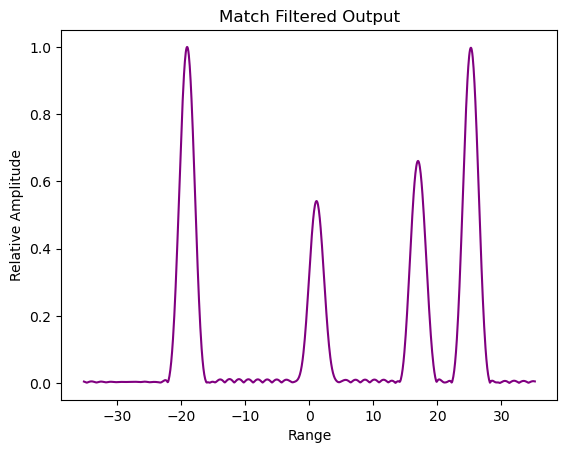

In [10]:
plt.plot(slant_range_window, np.abs(range_azimuth_space[0]) / np.max(np.abs(range_azimuth_space[0])), color='purple')
plt.title('Match Filtered Output')
plt.xlabel('Range')
plt.ylabel('Relative Amplitude')
plt.show()

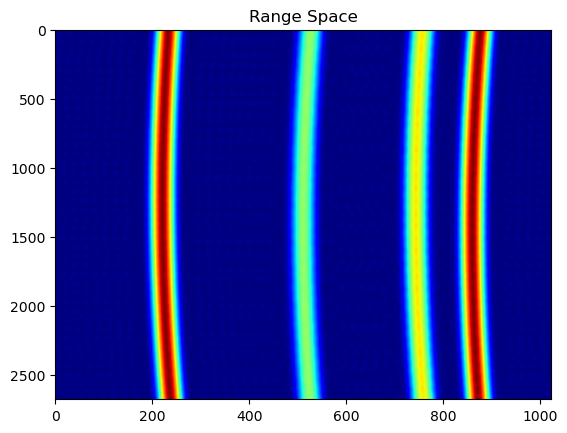

In [11]:
plt.imshow(np.abs(range_azimuth_space) / np.max(np.abs(range_azimuth_space)), cmap='jet', aspect='auto')
plt.title('Range Space')
plt.show()

### Conversion to Range-Doppler Domain

In [12]:
range_doppler_space = fftshift(fft(range_azimuth_space, axis=0), 0)

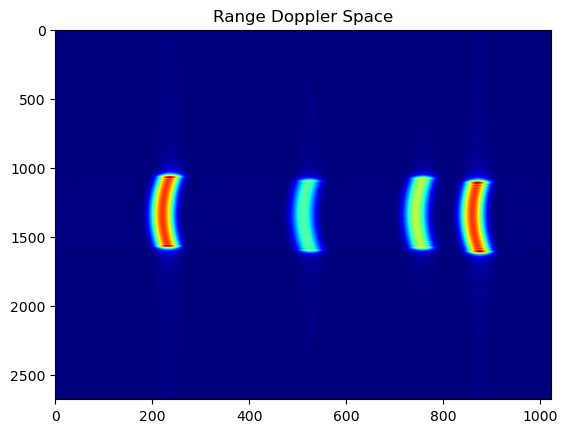

In [13]:
plt.imshow(np.abs(range_doppler_space) / np.max(np.abs(range_doppler_space)), cmap='jet', aspect='auto')
plt.title('Range Doppler Space')
plt.show()

### Perform Range Cell Migration Correction

In [14]:
range_offsets = (range_to_center / np.sqrt(1 - ((wavelength * frequency_shifts) / (2 * effective_velocity)) ** 2)) - range_to_center
range_offsets = np.round(range_offsets / slant_range_res)
frequency_shifts = frequency_shifts * 5

In [15]:
range_doppler_space_rcmc = np.zeros(range_doppler_space.shape, dtype=complex)
for range_offset_index in range(len(range_offsets)):
    range_doppler_space_rcmc[range_offset_index] = np.roll(
        range_doppler_space[range_offset_index],
        -int(range_offsets[range_offset_index])
    )

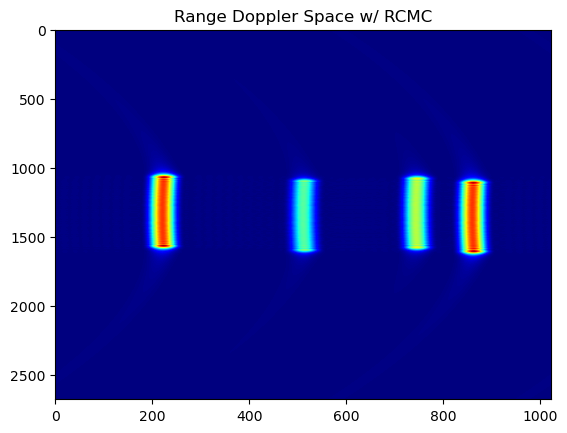

In [16]:
plt.imshow(np.abs(range_doppler_space_rcmc) / np.max(np.abs(range_doppler_space_rcmc)), cmap='jet', aspect='auto')
plt.title('Range Doppler Space w/ RCMC')
plt.show()

### Azimuth Compression

In [17]:
range_azimuth_space = ifft(ifftshift(range_doppler_space_rcmc, 0), axis=0)

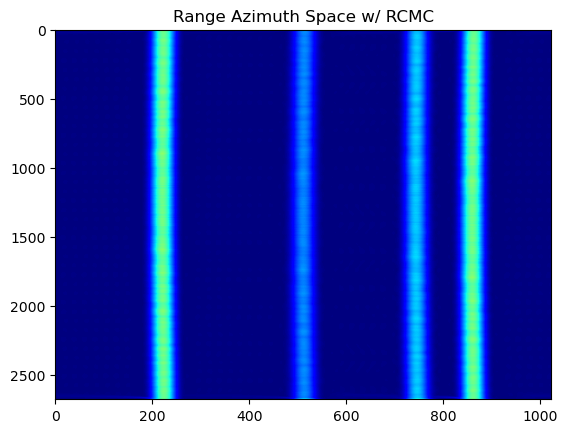

In [18]:
plt.imshow(np.abs(range_azimuth_space) / np.max(np.abs(range_azimuth_space)), cmap='jet', aspect='auto')
plt.title('Range Azimuth Space w/ RCMC')
plt.show()

In [19]:
image = np.zeros((num_fft_samples_az, num_fft_samples_rng), dtype=complex)
for i in range(num_fft_samples_rng):
    slant_range = slant_range_window[i]
    reference_frequency_slope = (synthetic_aperture**2) / (wavelength * (range_to_center + slant_range))
    filter_coefficients = np.hamming(num_samples_az)
    match_filter = fft(np.exp(1j * 4 * pi * reference_frequency_slope) * filter_coefficients, num_fft_samples_az)
    image[:, i] = ifftshift(ifft(fft(range_azimuth_space[:, i], num_fft_samples_az) * match_filter))

In [20]:
r = 0.5 * aperture_length * num_samples_az / num_fft_samples_az
cross_range = np.linspace(-r, r, num_fft_samples_az)
image_normalized = 20 * np.log10(np.abs(image) / np.max(np.abs(image)) + float_info.min)
dynamic_range = 35

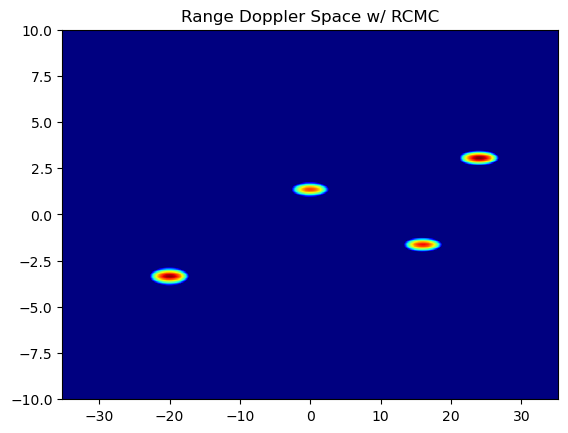

In [21]:
plt.figure
plt.pcolor(slant_range_window, cross_range + 45, image_normalized, cmap='jet', vmin=-dynamic_range, vmax=0)
plt.ylim([-10, 10])
plt.title('Range Doppler Space w/ RCMC')
plt.show()